# Branch Classifier

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import torch

sys.path.append("../")
from data_prep import collect, load
from solvers import branch_classifier
import models
date = datetime.now().strftime("%m-%d-%y")
dtype = torch.float32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Collect branch classifier training data
Training data consists of volumetric image patches chosen randomly from the neuron node coordinates given\
in the SWC file with an added small random translation. Image patches are labeled 1 if they are centered on\
 a branch point and 0 otherwise.

### Get sample points from swc files

In [7]:
# Load SWC file data into python lists
labels_dir = "/home/brysongray/data/neuromorpho_sub1"
files = [f for x in os.walk(labels_dir) for f in glob(os.path.join(x[0], '*.swc'))]
swc_lists = []
for f in files:
    swc_lists.append(load.swc(f))

# Collect random sample points from SWC data
samples_per_file = 50
fnames = [f.split('/')[-1].split('.')[0] for f in files]
sample_points = collect.swc_random_points(samples_per_file, swc_lists, fnames, adjust=True)

loading file: /home/brysongray/data/neuromorpho_sub1/beining/CNG version/35dpi_ipsi_infra_06.CNG.swc
loading file: /home/brysongray/data/neuromorpho_sub1/campos/CNG version/Astro-1.CNG.swc
loading file: /home/brysongray/data/neuromorpho_sub1/allen cell types/CNG version/646805498_transformed.CNG.swc


### Save sample patches and labels from image files

In [12]:
# save sample patches from the images centered at the sample points
image_dir = "/home/brysongray/data/simulated_neurons/neuromorpho_sub1_with_artifacts"
out_dir = "classifier_data"
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)
name = "neuromorpho_test"

collect.collect_data(sample_points, image_dir, out_dir, name, date)

### View some example input images

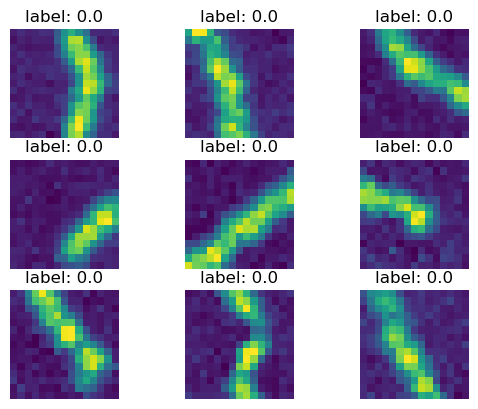

In [10]:
observations = os.listdir(os.path.join(out_dir, "observations"))
training_annotations = pd.read_csv(glob(os.path.join(out_dir, "*_labels.csv"))[0])
ids = np.random.choice(len(training_annotations), size=9)
sample = training_annotations.iloc[ids]

fig, ax = plt.subplots(3,3)
ax = ax.flatten()
for i in range(len(ax)):
    img = torch.load(os.path.join(out_dir,"observations", sample.iloc[i,0]), weights_only=True) # type: ignore
    ax[i].imshow(img[0].amax(0))
    ax[i].set_title(f"label: {sample.iloc[i,1].item()}")
    ax[i].set_axis_off()

    

## Train branch classifier

### Instantiate dataloader for training and test datasets
Dataloaders use a weighted random sampler to balance classes. Additionally, the training dataset\
 adds a random permutation and flip to the image patch at retrieval.

In [13]:
# set source data files paths
training_labels_file = "classifier_data/branch_classifier_neuromorpho_test_02-07-25_test_labels.csv"
test_labels_file = "classifier_data/branch_classifier_neuromorpho_test_02-07-25_training_labels.csv"
img_dir = "classifier_data/observations"

# instantiate training and test datasets
transform = branch_classifier.transform # random permutation and flip
training_data = branch_classifier.StateData(labels_file=training_labels_file,
                          img_dir=img_dir,
                          transform=transform)
test_data = branch_classifier.StateData(labels_file=test_labels_file,
                          img_dir=img_dir)

# instantiate dataloaders
training_dataloader = branch_classifier.init_dataloader(training_data)
test_dataloader = branch_classifier.init_dataloader(test_data)

## View balanced data

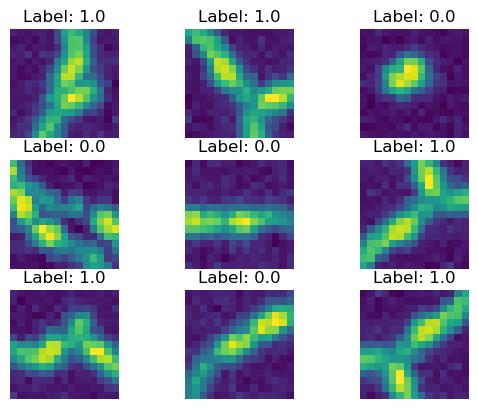

In [14]:
fig, axs = plt.subplots(3,3)
axs = axs.flatten()

X,y = next(iter(training_dataloader))
for i, ax in enumerate(axs):
    ax.imshow(X[i,0].amax(0))
    ax.set_title(f"Label: {y[i]}")
    ax.set_axis_off()

In [17]:
out_dir = "classifier_weights/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

lr = 1e-3
epochs = 5
classifier = models.ResNet(models.ResidualBlock, [3, 4, 6, 3], num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=dtype)

branch_classifier.train(training_dataloader, test_dataloader, out_dir, lr, epochs, classifier, state_dict=None)


Epoch 1
-------------------------------
Accuracy: 40.0, Loss: 0.405724  [   30/   30]
Test Error: 
 Accuracy: 50.0%, Avg loss: 24.919770 
           Precision: 0.500, Recall: 1.000
Epoch 2
-------------------------------
Accuracy: 76.66666666666667, Loss: 0.828855  [   30/   30]
Test Error: 
 Accuracy: 53.3%, Avg loss: 22.108765 
           Precision: 0.533, Recall: 1.000
Epoch 3
-------------------------------
Accuracy: 80.0, Loss: 0.543504  [   30/   30]
Test Error: 
 Accuracy: 51.7%, Avg loss: 23.350894 
           Precision: 0.517, Recall: 1.000
Epoch 4
-------------------------------
Accuracy: 70.0, Loss: 0.260397  [   30/   30]
Test Error: 
 Accuracy: 42.5%, Avg loss: 32.415985 
           Precision: 0.425, Recall: 1.000
Epoch 5
-------------------------------
Accuracy: 93.33333333333333, Loss: 0.181836  [   30/   30]
Test Error: 
 Accuracy: 48.3%, Avg loss: 26.552392 
           Precision: 0.483, Recall: 1.000
Done!
